<center> Scalable K-means++</center>
 ====
<center> Bai Li, Jialiang Mao </center>
----

Abstract
----
K-means algorithm is one of the most popular clustering algorithm. A crucial part of k-means algorithm is the choice of initial centers while a poor initial centers may lead to locally optimal solution. To beat this, the k-means++ initialization is proposed to obtain an initial set of centers that is close to the global optimum solution. However, because of its sequential nature, the k-means++ is not scalable. The paper introduces a scalable k-means++ algorithm by reducing the number of passes needed to obtain a good initialization. 

In this project, we implement this algorithm and test its performance with simulation studies. We also improve its performace by introducing Cython and vectorization.

1. Introduction
----

2. Implementation
----

In this section, we implement basic k-means, k-means++ and scalable k-means++. Note we also leave interfaces for cython so we can improve the performance later. 

In [39]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
import time
from random import randint
%matplotlib inline
%precision 7
plt.style.use('ggplot')

In [80]:
def data_generator(n):
    """ generate data that come from 5 clusters"""
    """ record which cluster they come from"""
    mean0 = [10,10,10]
    data0 = np.random.multivariate_normal(mean0, np.eye(3), n)
    data0 = np.hstack((data0, np.ones((data0.shape[0],1))))
    
    mean1 = [10,0,0]
    data1 = np.random.multivariate_normal(mean1, np.eye(3), n)
    data1 = np.hstack((data1, np.ones((data1.shape[0],1)) * 2))
    
    mean2 = [0,10,0]
    data2 = np.random.multivariate_normal(mean2, np.eye(3), n)
    data2 = np.hstack((data2, np.ones((data2.shape[0],1)) * 3))
    
    mean3 = [0,0,10]
    data3 = np.random.multivariate_normal(mean3, np.eye(3), n)
    data3 = np.hstack((data3, np.ones((data3.shape[0],1)) * 4))
    
    mean4 = [0, 0, 0]
    data4 = np.random.multivariate_normal(mean4, np.eye(3), n)
    data4 = np.hstack((data4, np.ones((data4.shape[0],1)) * 5))
    
    data = np.vstack((data0, data1, data2, data3,data4))
    np.random.shuffle(data)
    #print (data.shape)
    
    observation = data [:,0:3]
    cluster_number = data [:,3]-1
    return observation,cluster_number

In [92]:
def data_generator2(n):
    """ takes a number n and generates 3 times n data points with pre-specified 3 clusters."""
    mean0 = [3, 0]
    data0 = np.random.multivariate_normal(mean0, np.eye(2), n)
    data0 = np.hstack((data0, np.ones((data0.shape[0],1))))
    
    mean1 = [-3, 0]
    data1 = np.random.multivariate_normal(mean1, np.eye(2), n)
    data1 = np.hstack((data1, np.ones((data1.shape[0],1)) * 2))
    
    mean2 = [0, 5]
    data2 = np.random.multivariate_normal(mean2, np.eye(2), n)
    data2 = np.hstack((data2, np.ones((data2.shape[0],1)) * 3))
    
    data = np.vstack((data0, data1, data2))
    np.random.shuffle(data)
    
    #print (data.shape)
    observation = data [:,0:2]
    cluster_number = data [:,2]-1
    return observation,cluster_number

In [53]:
#define some measures that we will use

def squared_euclidean_norm(u, axis=-1):
    return((u**2).sum(axis))

def euclidean_norm(u, axis=-1):
    return np.sqrt(squared_euclidean_norm(u, axis))

def squared_euclidean_dist(u, v, axis=-1):
    """Returns squared Euclidean distance between two vectors."""
    return squared_euclidean_norm(u-v, axis)

def min_squared_euclidean_dist(uV, v, axis=-1):
    """Returns the minimum of Euclidean distance between a list of vectors and a vector v"""
    minimum_dis_array = squared_euclidean_dist(uV[0],v)
    for i in range(0,len(uV)):
        minimum_dis_array = np.minimum(squared_euclidean_dist(uV[i],v),minimum_dis_array)
    return minimum_dis_array

def euclidean_dist(u, v, axis=-1):
    """Return Euclidean distacne between two vectors."""
    return np.sqrt(squared_euclidean_dist(u, v, axis))

In [31]:
def K_Means_basic(k,DATA, initial_centroid,advanced = False, isCython =False):
    updated_centroid = initial_centroid
    if not advanced: # meaning it is just a basic version, we sample 5 random points as our cluster
        updated_centroid = DATA[np.random.choice(range(DATA.shape[0]),k), :]
        
    count, count2 = 0,0
    n_feature = len(DATA[0])
    assignment,assignment2 = np.ones(len(DATA)),np.zeros(len(DATA))
    
    while not np.array_equal(assignment,assignment2) : #if the labeling of cluster do not change
        assignment2=assignment.copy()
        for i in range(0,len(DATA)):
            count = count +1
            if not isCython:
                dist_array = euclidean_dist(updated_centroid,DATA[i]) # find the distance array 
            if isCython:
                dist_array = euclidean_dist_cython(updated_centroid,DATA[i])
            assignment[i] = min(np.asarray(np.where(dist_array[:]==min(dist_array))))[0]
        for j in range(0,k):
            #updates the cnetroid
            updated_centroid[j] = np.mean(DATA[np.where(assignment[:]==j)][:,0:n_feature], axis=0)
        count2 = count2 +1
    return updated_centroid,assignment

In [6]:
def K_Means_plusplus(k,DATA,isCython = False):
    random_point_index = randint(0,len(DATA))
    center = []
    center.append(DATA[random_point_index]) #Sample a point uniformly at random from X
    phi_x_C_vector = squared_euclidean_dist(center[0],DATA)
    p_x = phi_x_C_vector/sum(phi_x_C_vector) #Calculate the weight probability
    cluster2 = []
    while len(center) < k:
        nnn = np.random.multinomial(1,p_x).tolist() # sample a point with the weight probability
        loc1 = nnn.index(max(nnn))
        center.append(DATA[loc1])
        phi_x_C_vector = min_squared_euclidean_dist(center,DATA)
        p_x = phi_x_C_vector/sum(phi_x_C_vector) #updates the weight probability
    return K_Means_basic(k,DATA,np.array(center),True,isCython)

In [54]:
def Scalable_K_Means(k,l,DATA,isCython=False):
    random_point_index = randint(0,len(DATA))
    center = []
    center.append(DATA[random_point_index]) #Sample a point uniformly at random from X
    
    phi_x_C_vector = squared_euclidean_dist(center[0],DATA)
    p_x = (l*phi_x_C_vector) / sum(phi_x_C_vector) #Calculate the weight probability
    
    for itjj in range(0,int(np.log(sum(phi_x_C_vector)))):
        uniform_p = np.random.uniform(0,1,len(DATA))
        
        for itj in range(0,len(DATA)):
            if uniform_p[itj] < p_x[itj]:
                center.append(DATA[itj]) # sample each point x<- X independently
                
            phi_x_C_vector = min_squared_euclidean_dist(center,DATA) 
            p_x = l*phi_x_C_vector/sum(phi_x_C_vector)
            
    w_x_vector = np.zeros(len(center))
    
    if isCython: #put if statment outside of the for loop
        center_array = np.asarray(center)
        for i in range(0,len(DATA)):
            nn = euclidean_dist_cython(center_array,DATA[i]).tolist()
            loc = nn.index(min(nn))
            w_x_vector[loc] = w_x_vector[loc] + 1
    if not isCython:
        for i in range(0,len(DATA)):
            nn = euclidean_dist(center,DATA[i]).tolist()
            loc = nn.index(min(nn))
            w_x_vector[loc] = w_x_vector[loc] + 1
    
    w_x_vector_prob = w_x_vector/sum(w_x_vector)
    center2 = []
    
    while len(center2) < k:
        nnn = np.random.multinomial(1,w_x_vector_prob).tolist() # sample a point with the weight 
        loc1 = nnn.index(max(nnn))
        center2.append(center[loc1])
        phi_x_C_vector = min_squared_euclidean_dist(center2,center)
        p_x = phi_x_C_vector/sum(phi_x_C_vector)
    #print center2
    return K_Means_basic(k,DATA,np.asarray(center2),True,isCython)

3. Testing
----

In [85]:
X,y = data_generator(100)
initial_centroid2 = np.array([X[1],X[1],X[1],X[1],X[1]])

In [86]:
X2,y2 = data_generator2(100)
initial_centroid = np.array([X2[1],X2[1],X2[1]])

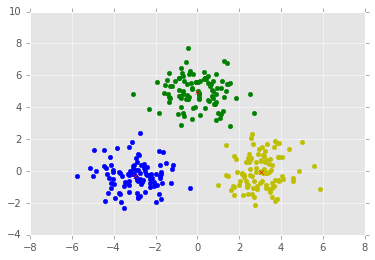

In [87]:
centers,index = K_Means_basic(3,X2,initial_centroid)
cols=iter(['b','g','y'])
for i in range (3):
    plt.scatter(X2[index == i][:,0], X2[index == i, :][:,1], color=next(cols))
plt.scatter(centers[:,0], centers[:,1], color='r', marker='x')

The plot shows our basic k-means algorithm works well.

In [88]:
%%time
res_basic=K_Means_basic(5,X,initial_centroid2)

Wall time: 46.3 ms


In [89]:
%%time
res_pp=K_Means_plusplus(5,X)

Wall time: 38.6 ms


In [90]:
%%time
res_SK=Scalable_K_Means(5,1,X)

Wall time: 2.33 s


E:\Anaconda\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


It can be observed that the non-parallelized Scalable k-means is much slower than the basic version of k-means

4. Optimization with Cython
----